In [1]:
from itertools import combinations
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import logistic

from numba import njit
# creating type hints for numba
from numba import float64, int64
from numba import types as nbtypes
from numba import f8, i8, b1
from numba.typed import Dict

bool_1d      = nbtypes.Array(dtype=b1, ndim=1, layout="A")
bool_1d_ro   = nbtypes.Array(dtype=b1, ndim=1, layout="A", readonly=True)
bool_2d      = nbtypes.Array(dtype=b1, ndim=2, layout="A")

int_1d       = nbtypes.Array(dtype=i8, ndim=1, layout="A")
int_1d_ro    = nbtypes.Array(dtype=i8, ndim=1, layout="A", readonly=True)
int_2d       = nbtypes.Array(dtype=i8, ndim=2, layout="A")
int_2d_ro    = nbtypes.Array(dtype=i8, ndim=2, layout="A", readonly=True)
int_3d       = nbtypes.Array(dtype=i8, ndim=3, layout="A")

flt_1d       = nbtypes.Array(dtype=f8, ndim=1, layout="A")
flt_1d_ro    = nbtypes.Array(dtype=f8, ndim=1, layout="A", readonly=True)
flt_2d       = nbtypes.Array(dtype=f8, ndim=2, layout="A")
flt_2d_ro    = nbtypes.Array(dtype=f8, ndim=2, layout="A", readonly=True)
flt_3d        = nbtypes.Array(dtype=f8, ndim=3, layout="A")
flt_3d_ro     = nbtypes.Array(dtype=f8, ndim=3, layout="A", readonly=True)
flt_4d        = nbtypes.Array(dtype=f8, ndim=4, layout="A")
flt_4d_ro     = nbtypes.Array(dtype=f8, ndim=4, layout="A", readonly=True)

In [2]:
# count the number of cells in each grid unit
@ njit(int_2d (i8,        int_2d_ro    ))
def cell_counts(grid_size, cell_positions):
    counts = np.zeros((grid_size, grid_size), dtype = np.int64)
    for pos in cell_positions:
        counts[pos[0],pos[1]] += 1

    return counts

# get the position for each cell given a starting count in each grid unit
def cell_positions(population_grid):
    local_grid = deepcopy(population_grid)
    coordinates = []
    for i in range(population_grid.shape[0]):
        for j in range(population_grid.shape[1]):
            while local_grid[i, j] > 0:
                coordinates.append(np.array([i, j]))
                local_grid[i, j] -= 1
            
    return np.array(coordinates, dtype = np.int64)

# resample a temporal array into less timepoints
def temporal_resample(input_array, samples):
    results = np.zeros((samples, input_array.shape[1], input_array.shape[2]))
    index_to_sample_at = np.trunc(np.linspace(0, input_array.shape[0]-1, samples)).astype(np.int64)
    for i in range(samples):
        results[i,:,:] = input_array[index_to_sample_at[i],:,:]
        
    return results

@njit(flt_2d     (flt_2d, f8  ))
# determininstic diffusion of signalling molecules in 2d
def deter_diff_2d(grid,   rate):

    diff_right = grid[  :  ,  :-1]*rate
    diff_left  = grid[  :  , 1:  ]*rate
    diff_up    = grid[ 1:  ,  :  ]*rate
    diff_down  = grid[  :-1,  :  ]*rate

    grid[  :  ,  :-1] -= diff_right
    grid[  :  , 1:  ] += diff_right

    grid[  :  , 1:  ] -= diff_left
    grid[  :  ,  :-1] += diff_left

    grid[ 1:  ,  :  ] -= diff_up
    grid[  :-1,  :  ] += diff_up

    grid[  :-1,  :  ] -= diff_down
    grid[ 1:  ,  :  ] += diff_down
    
    return grid

@njit(               (flt_3d, f8  ))
# determininstic diffusion of signalling molecules in 2d
def deter_diff_2d_all(grid,   rate):

    diff_right = grid[  :  ,  :-1, 1: 4]*rate
    diff_left  = grid[  :  , 1:  , 1: 4]*rate
    diff_up    = grid[ 1:  ,  :  , 1: 4]*rate
    diff_down  = grid[  :-1,  :  , 1: 4]*rate

    grid[  :  ,  :-1, 1: 4] -= diff_right
    grid[  :  , 1:  , 1: 4] += diff_right

    grid[  :  , 1:  , 1: 4] -= diff_left
    grid[  :  ,  :-1, 1: 4] += diff_left

    grid[ 1:  ,  :  , 1: 4] -= diff_up
    grid[  :-1,  :  , 1: 4] += diff_up

    grid[  :-1,  :  , 1: 4] -= diff_down
    grid[ 1:  ,  :  , 1: 4] += diff_down
    
 
                

[[18 10 19  9 22]
 [16 12 16 12 13]
 [13 13 21 13 15]
 [19  9 25  9 18]
 [15 24 14 26 19]]
17


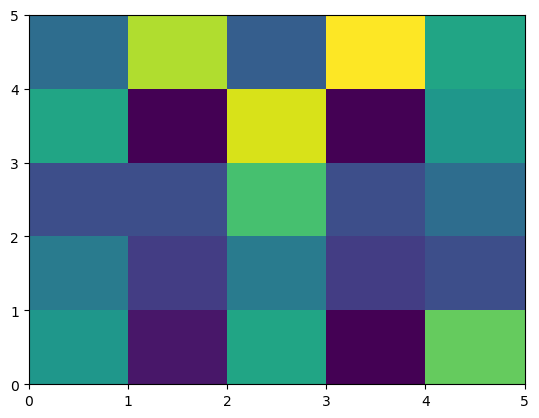

In [3]:
n_cells = 400
diff_rate = 0.0005

grid_size = 5
grid_size_lim = grid_size -1

cell_pos = np.random.randint(0, grid_size, n_cells*2).reshape(n_cells, 2)
cell_c = cell_counts(grid_size, cell_pos)
print(cell_c); print(np.max(cell_c) - np.min(cell_c))
plt.pcolormesh(cell_c)

[[18 14 12 15 13]
 [17 15 19 22 14]
 [13 17 18 12 16]
 [19 17 15  8 19]
 [20 12 18 18 19]]
14


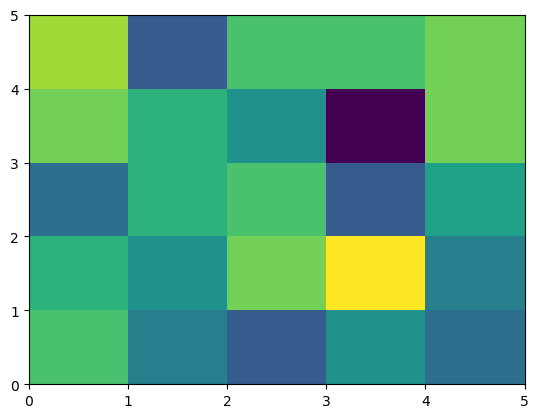

In [4]:
for i in range(1000):
    coordinate_mod = np.zeros((2, 2, n_cells), dtype = np.int64)

    coordinate_mod[0][0] = (cell_pos[:,0] < grid_size_lim)
    coordinate_mod[0][1] = -1*(cell_pos[:,0] > 0)
    coordinate_mod[1][0] = (cell_pos[:,1] < grid_size_lim)
    coordinate_mod[1][1] = -1*(cell_pos[:,1] > 0)
    
    mod_amount = np.random.binomial(1, diff_rate, n_cells*4).reshape(2, 2, n_cells)

    final_mod = (coordinate_mod*mod_amount).sum(axis = 1).swapaxes(1,0)
    #print(final_mod)

    cell_pos += final_mod

cell_c = cell_counts(grid_size, cell_pos)
print(cell_c); print(np.max(cell_c) -np.min(cell_c))
plt.pcolormesh(cell_c)

In [5]:
# handles the initialization of data structures used in the simulation
def grid_simulation_setup(starting_env, het_env, het_cell, cell_start_state, starting_pop, grid_size, time):
    
    starting_env   = np.array([starting_env[element] for element in starting_env])
    
    ## array containing the starting population counts in each grid cell
    start_pop_grid = np.tile(starting_pop, (grid_size, grid_size))
        # starting dictyostelium counts can be varied according to het_start_dens
    if het_env > 0:
        start_pop_grid = np.random.normal(1, het_env, (grid_size, grid_size))*start_pop_grid  
        # truncate to integer values
        start_pop_grid = np.array(np.round(start_pop_grid, 0), dtype = np.int64)
        # clip to ensure no negative values
        np.clip(start_pop_grid, a_min = 1, a_max = None, out = start_pop_grid) 
        
        # count the total number of cells
    n_cells = int(start_pop_grid.sum())
    
    ## lists containing the states of each cell, 9/10ths of the starting arrays are meant to be uninitialized
    # list containing the state of each cell
    list_cell_state = np.array([np.array([cell_start_state[key] for key in cell_start_state]) for _ in range(n_cells*10)], dtype = np.int64)
    if het_cell > 0:
        for i in range(n_cells):
            # create heterogeneity in signal sensitivity
            list_cell_state[i][19] = int(np.random.normal(1, het_cell)*100)
            # create heterogeneity in signal production
            list_cell_state[i][20] = int(np.random.normal(1, het_cell)*100)

    # list containing the position of each cell
    list_cell_pos = cell_positions(start_pop_grid)
    list_cell_pos = np.append(list_cell_pos, np.tile(np.array([-1, -1], dtype = np.int64), (n_cells*9,1))) # pad with [-1,-1] for cells that are currently inactive
    list_cell_pos = list_cell_pos.reshape(n_cells*10, 2)

    # list containing the age of each cell
    list_cell_age = np.array([0 for _ in range(n_cells)], dtype = np.int64)
    list_cell_age = np.append(list_cell_age, np.repeat(-1, n_cells*9)) # pad with -1 for cells that are currently inactive

    
    ## array containing the starting signalling environment in each grid cell
        # starting state of the grid, all grid units are identical
    env_grid = np.tile(starting_env, (grid_size, grid_size,1))
    # available bacteria is varied according to environmental heterogeneity
    if het_env > 0:
        env_grid = np.random.normal(1, het_env, (grid_size, grid_size, 4))*env_grid
        # clip to ensure no values under 0
        np.clip(env_grid, a_min = 0, a_max = None, out = env_grid) 
        
    # # vary the starting psf and cmf levels in accordance with the starting population and nutrient availability
    # if het_env > 0:
    #     for i in range(grid_size):
    #         for j in range(grid_size):
    #             # add starting psf according to starting population
    #             env_grid[i, j, 1] = start_pop_grid[i, j]*2
            
    
    # array holding the state of the environment over time
    env_t       = np.zeros((time, grid_size, grid_size, 4), dtype = np.float64)
    
    # array holding cell counts in each grid unit over time
    cellcount_t = np.zeros((time, grid_size, grid_size),    dtype = np.int64)
    
    
    return n_cells, env_grid, list_cell_state, list_cell_pos, list_cell_age, env_t, cellcount_t

# handles the initialization of data structures used in the simulation
def cell_simulation_setup(starting_env, cell_start_state, time):
    
    starting_env   = np.array([starting_env[element] for element in starting_env], dtype = np.float64)
    cell_state     = np.array([cell_start_state[key] for key in cell_start_state], dtype = np.int64)
    
    # array holding the state of the environment over time
    env_t        = np.zeros((time, 4), dtype = np.float64)
    
    # array holding cell states over time
    cell_state_t = np.zeros((time, cell_state.size), dtype = np.int64)
    
    
    return starting_env, cell_state, env_t, cell_state_t

In [6]:
# given the results of the simulation, infer the timing of aggregation competence
def aggregation_competence(cellcount_t, list_cell_state):
    time = cellcount_t.shape[0]
    
    n_cells_over_time = cellcount_t.sum(axis = (1,2))
    n_cells = n_cells_over_time[-1]
    
    agg_compet_first_array = list_cell_state[0:n_cells, 22]
    n_agg_cells_over_time = np.array([((agg_compet_first_array > 0) & (agg_compet_first_array < i)).sum() for i in range(time)])
    
    # proportion of cells with aggregation competence
    agg_comp_prop = n_agg_cells_over_time/n_cells_over_time    
    
    # average waiting time between two cells
    median_wait = np.round(np.average([np.abs(element[0] - element[1]) for element in combinations(agg_compet_first_array, 2)]), 2)
    
    return agg_comp_prop, agg_compet_first_array, median_wait

def plot_simulation_results(time, env_t, cellcount_t, list_cell_state, list_cell_age, list_cell_pos):
    # collect signal levels
    level_bac  = env_t[:,:,:,0]
    level_bac_mean = np.average(level_bac, axis = (1,2))
    level_bac_lc = np.quantile(level_bac, 0.05, axis = (1,2))
    level_bac_uc = np.quantile(level_bac, 0.95, axis = (1,2))
    min_bac = 0; max_bac = np.max(level_bac)
    
    level_PSF  = env_t[:,:,:,1]
    level_PSF_mean = np.average(level_PSF, axis = (1,2))
    level_PSF_lc = np.quantile(level_PSF, 0.05, axis = (1,2))
    level_PSF_uc = np.quantile(level_PSF, 0.95, axis = (1,2))
    min_PSF = 0; max_PSF = np.max(level_PSF)
    
    level_CMF  = env_t[:,:,:,2]
    level_CMF_mean = np.average(level_CMF, axis = (1,2))
    level_CMF_lc = np.quantile(level_CMF, 0.05, axis = (1,2))
    level_CMF_uc = np.quantile(level_CMF, 0.95, axis = (1,2))
    min_CMF = 0; max_CMF = np.max(level_CMF)
    
    level_cAMP = env_t[:,:,:,3]
    level_cAMP_mean = np.average(level_cAMP, axis = (1,2))
    level_cAMP_lc = np.quantile(level_cAMP, 0.05, axis = (1,2))
    level_cAMP_uc = np.quantile(level_cAMP, 0.95, axis = (1,2))

    # calculate timing of aggregation competence
    agg_comp_prop, agg_compet_first_array, median_wait = aggregation_competence(cellcount_t, list_cell_state)
    latest_agg = int(np.max(agg_compet_first_array))
    
    min_cAMP = 0; max_cAMP = np.max(level_cAMP[latest_agg])
    
    min_cell = 0; max_cell = np.max(cellcount_t)
    
    
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    
    ## SIGNAL LEVELS OVER TIME
    ax1.plot(np.arange(0, time), level_bac_mean, label = "bacteria")
    ax1.fill_between(np.arange(0, time), level_bac_lc, level_bac_uc, alpha = 0.1)
    ax1.plot(np.arange(0, time), level_PSF_mean, label = "PSF")
    ax1.fill_between(np.arange(0, time), level_PSF_lc, level_PSF_uc, alpha = 0.1)
    ax1.plot(np.arange(0, time), level_CMF_mean, label = "CMF")
    ax1.fill_between(np.arange(0, time), level_CMF_lc, level_CMF_uc, alpha = 0.1)
    ax1.plot(np.arange(0, time), level_cAMP_mean, label = "cAMP")
    ax1.fill_between(np.arange(0, time), level_cAMP_lc, level_cAMP_uc, alpha = 0.1)
    ax1.legend(loc = "upper left")
    ax1.set_ylim([0, 100])
    
    ## CELL COUNTS OVER TIME
    cellcount_per_grid_t = np.array([element.flatten() for element in cellcount_t])
    mean_cell_count = np.mean(cellcount_per_grid_t, axis = 1)
    #ax2.plot(np.arange(0, time), np.sum(cellcount_t, axis = (1, 2)), label = "total cell count")
    for i in range(0, grid_size*grid_size):
        ax2.plot(np.arange(0, time), cellcount_per_grid_t[:, i], alpha = 0.1)
    ax2.plot(np.arange(0, time), mean_cell_count, color = "b", linewidth = 2, label = "mean # of cells / grid")
    ax2.legend(loc = "lower right")


    ax3.plot(np.arange(0, time), agg_comp_prop, label = "proportion of aggregation competent cells")
    ax3.legend(loc = "upper left")

    ax4.hist(agg_compet_first_array, range = (0, time), bins = 20, 
             histtype = "stepfilled", density = False, alpha = 0.4, 
             label = f"# of cells gaining\naggregation competence")
    ax4.legend(loc = "upper left")
    plt.show()

    # print results
    print("mean time of aggregation:", np.round(np.mean(agg_compet_first_array), 2))
    print("standard deviateion in the time of aggregation:", np.round(np.std(agg_compet_first_array), 2))
    print("mean pairwise difference in the time of aggregation:", median_wait)

    fig2, ((ax1, ax5), (ax2, ax6), (ax4, ax8)) = plt.subplots(3, 2, figsize=(9,8), layout="constrained")
    
    im1 = ax1.pcolormesh(cellcount_t[0,:,:], cmap='RdBu', vmin=min_cell, vmax=max_cell)
    ax1.set_title('starting cell counts')
    im2 = ax2.pcolormesh(level_bac[0,:,:], cmap='RdBu', vmin=min_bac,vmax=max_bac)
    ax2.set_title('starting bacterial levels')
    # im3 = ax3.pcolormesh(level_CMF[0,:,:], cmap='RdBu', vmin=min_CMF,vmax=max_CMF)
    # ax3.set_title('starting CMF levels')
    im4 = ax4.pcolormesh(level_cAMP[0,:,:], cmap='RdBu', vmin=min_cAMP,vmax=max_cAMP)
    ax4.set_title('starting cAMP levels')
    
    im5 = ax5.pcolormesh(cellcount_t[latest_agg,:,:], cmap='RdBu', vmin=min_cell, vmax=max_cell)
    ax5.set_title('cell counts at aggr.')
    im6 = ax6.pcolormesh(level_bac[latest_agg,:,:], cmap='RdBu', vmin=min_bac,vmax=max_bac)
    ax6.set_title('bacterial levels at aggr.')
    # im7 = ax7.pcolormesh(level_CMF[latest_agg,:,:], cmap='RdBu', vmin=min_CMF,vmax=max_CMF)
    # ax7.set_title('CMF levels at aggr.')
    im8 = ax8.pcolormesh(level_cAMP[latest_agg,:,:], cmap='RdBu', vmin=min_cAMP,vmax=max_cAMP)
    ax8.set_title('cAMP levels at aggr.')
    
    fig2.colorbar(im1, ax=[ax1, ax5])
    fig2.colorbar(im2, ax=[ax2, ax6])
    #fig2.colorbar(im3, ax=[ax3, ax7])
    fig2.colorbar(im4, ax=[ax4, ax8])
    
    
    plt.show()

In [7]:
# function for logistic sensing
    # curve is precalculated, so that the function only performs a lookup 
LOGISTIC_SENSE = np.array(100*logistic.cdf(np.arange(0, 2000), loc = 70, scale = 12), dtype = np.float64)
LOGISTIC_SENSE[0:5] = 0.0 # set first values to 0 (these would be non-zero by default, leading to activation even without a signal)
#plt.plot(np.arange(0, 2000), logistic_result)


# signal molecule sensor with logistic sensitivity
@njit(b1   (f8))
def log_sens(signal): 
    if np.random.uniform(0, 100) < signal:#LOGISTIC_SENSE[int(signal)]:
        return True
    else:
        return False

# does event with probabiltity 'prob' occur?
@njit(b1   (f8))
def chance_event(prob): 
    if np.random.uniform(0, 1) < prob:
        return True
    else:
        return False
    
# function for logistic division probabilty
LOGISTIC_DIV = np.array(logistic.cdf(np.arange(0, 200), loc = 90, scale = 4), dtype = np.float64)
LOGISTIC_DIV[0:5] = 0.0 # set first values to 0 (these would be non-zero by default, leading to activation even without a signal)
#plt.plot(np.arange(0, 200), LOGISTIC_DIV)

@njit(b1 (f8))
def log_div(nutrients): 
    if np.random.uniform(0, 1) < LOGISTIC_DIV[int(nutrients)]:
        return True
    else:
        return False

SIG_I = {'bac': 0, 'PSF': 1, 'CMF': 2, 'cAMP': 3,}

# S_I contains the mapping of internal state variables to their names
S_I = {          
    # sensors for external signalling molecules
    "exts_bac"  : 0,  "exts_PSF"  : 1,  "exts_CMF"  : 2,  "exts_cAMP" : 3,
    # cmf latch     
    "CMF_latch" : 4,
    # internal mRNA levels and internal sensors of mRNA levels
    "mrna_YakA" : 5,  "ints_YakA" : 6,
    "mrna_PKA"  : 7,  "ints_PKA"  : 8,
    "mrna_ACA"  : 9,  "ints_ACA"  : 10,
    "mrna_CAR1" : 11, "ints_CAR1" : 12,
    "mlcl_cAMP" : 13, "ints_cAMP" : 14,
    # whether to produce or consume chemicals
    "eat_bac"   : 15, "prod_PSF"  : 16, "prod_CMF"  : 17, "prod_cAMP" : 18,
    # sensing and production biases    
    "exts_bias" : 19, "prod_bias" : 20,
    # expression level of developmental genes    
    "dev_genes" : 21, "agg_comp_t": 22,
    # external switch for cAMP export (otherwise all cAMP is maintained internally)
    "exprt_cAMP": 23,
    # measure of how well the cell is fed
    "nutrients": 24, "starving": 25
    }

# indeces of state variables beloning to mRNA levels
MRNA_I = np.array([5, 7, 9, 11, 13, 21, 24], dtype = np.int64)

In [8]:
asd = 1
asd = asd*0.999
np.round(asd, 0)

1.0

In [11]:
# logic of boolean gene network. 
@njit(flt_1d (i8,  int_1d, flt_1d_ro,  flt_1d_ro))
def gdp_bc(   t,   state,  ext_signal, prod_rate):
    
    # rescaling of sensing and production bias to center around 1.0
    exts_bias = state[19]/100
    prod_bias = state[20]/100
    
    ## sensing external signals
    state[0] = log_sens(ext_signal[0]*exts_bias*10) # bac
    state[1] = log_sens(ext_signal[1]*exts_bias)  # PSF
    state[2] = log_sens(ext_signal[2]*exts_bias)  # CMF
    state[3] = log_sens(ext_signal[3]*exts_bias)  # cAMP
    
    if state[24] < 1: state[25] = 1
    
    ## sense internal mRNA concentrations
    state[6]  = log_sens(state[5])  # YakA
    state[8]  = log_sens(state[7])  # PKA
    state[10] = log_sens(state[9])  # ACA
    state[12] = log_sens(state[11]) # CAR1
    state[14] = log_sens(state[13]) # cAMP
    
    ## Increase nutrient state if bacteria was sensed, and decrease if not
    if state[0]:
        state[24] += 1 
    else:
        state[24] -=1
    
    ## ADJUST INTERNAL MRNA LEVELS
    # increase YakA mrna levels if there are no bacteria and PSF is present
    if not state[0] and state[1]: state[5] += 1
    
    # increase PKA mrna based on YakA mrna 
    if state[6]: state[7] += 1
    
    # increase CAR1 mrna and ACA mrna based on PKA mrna levels
    if state[8]:
        if chance_event(0.5):
            state[11] += 1
        else:
            state[9] += 1
    
        ## CAR1-ACA-CAMP LOOP
    # enable CAR1 activation of ACA if CMF was detected (activates permanently)
    if state[2]: state[4] = 1
    
    # increase CAR1 mrna levels if extrnal cAMP is detected
    if state[3]: state[11] += 1
    
    # increase ACA mrna if CAR1 mrna is present at high levels and the latch is closed
    if state[4] and state[12]: state[9] += 1
    
    # increase internal cAMP molecule levels if ACA is active
    if state[10]: state[13] += 2
    
    ## SET THE EXPORT OF SIGNALLING MOLECULES
    # stop eating bacteria if they are not available
    state[15] = 0 if (ext_signal[0] <= 0) else 1
    
    # psf is always produced
    state[16] = 1 
    
    # activate CMF export based on starvation status
    state[17] = 1 if state[25] else 0

    # export cAMP if ACA mrna is present at high levels (and if export cAMP is 1)
    state[18] = 1 if state[8] and state[23] else 0
    
    ## secretion
    signal_mlcl_secrete = [
        prod_bias*prod_rate[0]*state[15],           # bac
        prod_bias*prod_rate[1]*state[16],           # PSF
        prod_bias*prod_rate[2]*state[17],           # CMF
        prod_bias*prod_rate[3]*state[18]*state[13], # cAMP
        ]
    
    ## CHECK DEVELOPMENTAL COMPETENCE, AND RECORD TIMING
    # express developmental genes if PKA mRNA and CAR1 are sensed
    if state[8] and state[12]: state[21] += 1
    
    # express developmental genes in response to cAMP signalling
    if state[3]: state[21] += 1
        
    # check timing of inital aggregation competence:
    if state[22] == -1 and state[21] > 95: state[22] = t
    
    # clip mrna levels to avoid any overflows or underflows
    state[MRNA_I] = np.clip(state[MRNA_I], a_min = 0, a_max = 100)
    
    return np.array(signal_mlcl_secrete)

# simulation a single dicty cell
@njit(                 (i8,   flt_1d,   flt_1d_ro, int_1d,          flt_2d, int_2d      ))
def simulate_dicty_cell(time, env_grid, prod_rate, list_cell_state, env_t,  cell_state_t):
    
    env_t[0,:]        = env_grid
    cell_state_t[0,:] = list_cell_state
    
    # loop through each timepoint
    for t in np.arange(1, time, dtype = np.int64):

        # secrete signalling molecules, and update cell state according to the activity of the gdp
        env_grid += gdp_bc(t, list_cell_state, env_grid, prod_rate)
            
        # collect results for the iteration
        env_t[t,:]        = env_grid
        cell_state_t[t,:] = list_cell_state

# simulation of dictyostelium on the grid
@njit(                 (i8,   i8,      flt_3d,   flt_1d_ro, flt_1d_ro ,     int_2d,          int_2d,        int_1d,        flt_4d,  int_3d     ))
def simulate_dicty_grid(time, n_cells, env_grid, prod_rate, list_diff_rate, list_cell_state, list_cell_pos, list_cell_age, env_t,   cellcount_t):
    
    grid_size = env_grid.shape[0]
    n_cells = n_cells
    
    env_t[0,:,:]       = env_grid
    cellcount_t[0,:,:] = cell_counts(grid_size, list_cell_pos[0:n_cells])
    
    # loop through each timepoint
    for t in np.arange(1, time, dtype = np.int64):

        # loop through each cell in the sumulation
        for j in np.arange(0, n_cells, dtype = np.int64):
            cell     = list_cell_state[j]
            cell_pos = list_cell_pos[j]

            # secrete signalling molecules, and update cell state according to the activity of the gdp
            env_grid[cell_pos[0],cell_pos[1],:] += gdp_bc(t, cell, env_grid[cell_pos[0],cell_pos[1],:], prod_rate)
            
            # # replicate with a chance of 1/500 if food is available
            # if log_div(cell[24]) and chance_event(0.01):
            #     cell[24] = 10
            #     n_cells += 1
            #     list_cell_state[n_cells] = cell 
            #     list_cell_pos[n_cells]   = cell_pos
            #     list_cell_age[n_cells]   = t

        # diffuse signalling molecules at their own rates
        env_grid[:,:,1] = deter_diff_2d(env_grid[:,:,1], list_diff_rate[0]) # PSF
        env_grid[:,:,2] = deter_diff_2d(env_grid[:,:,2], list_diff_rate[1]) # CMF
        env_grid[:,:,3] = deter_diff_2d(env_grid[:,:,3], list_diff_rate[2]) # cAMP
        

        # collect results for the iteration
        env_t[t,:,:]       = env_grid
        cellcount_t[t,:,:] = cell_counts(grid_size, list_cell_pos[0:n_cells])

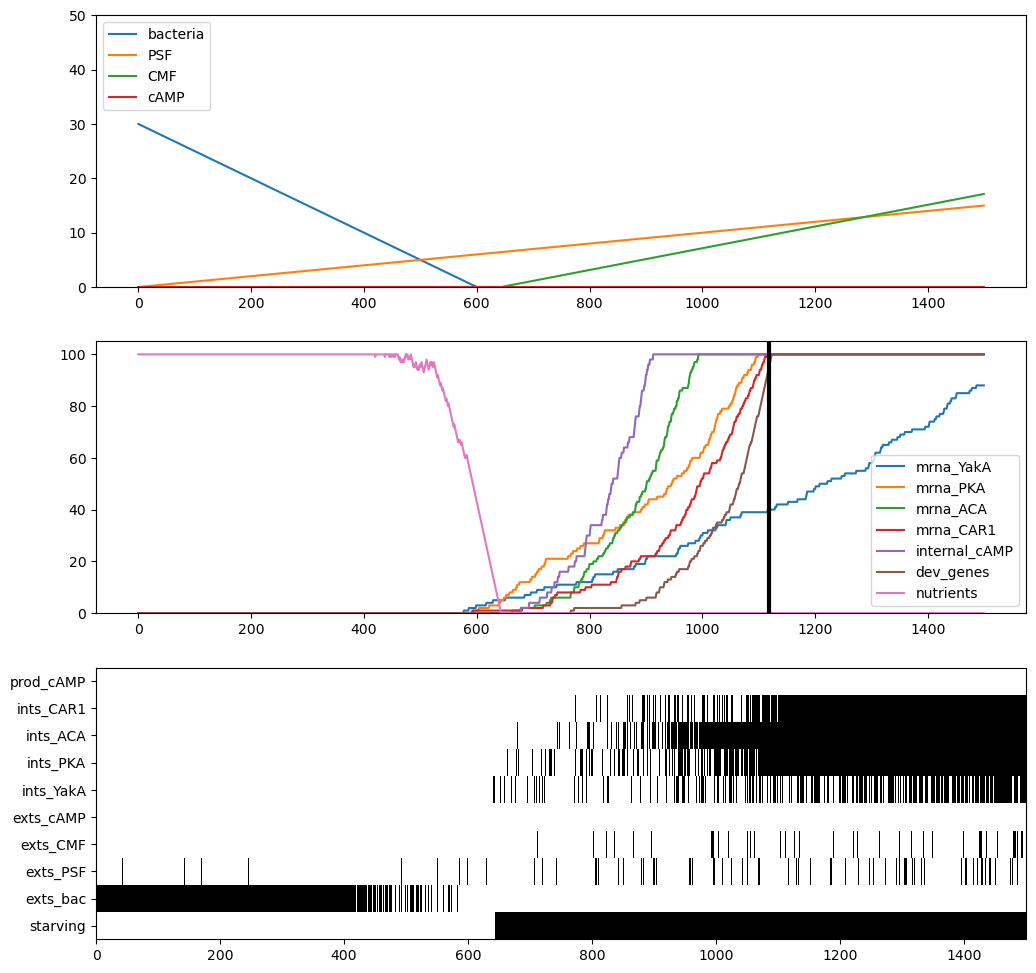

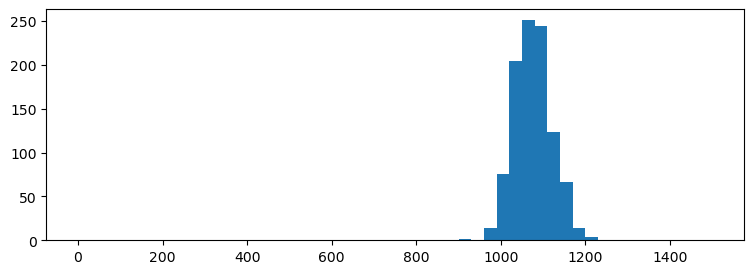

In [12]:
# elements of boolean gene network
gdp_start_state_dict = {
    "exts_bac"  : 1, "exts_PSF"  : 0, "exts_CMF"  : 0, "exts_cAMP" : 0,
    "CMF_latch" : 0,
    "mrna_YakA" : 0, "ints_YakA" : 0,
    "mrna_PKA"  : 0, "ints_PKA"  : 0,
    "mrna_ACA"  : 0, "ints_ACA"  : 0,
    "mrna_CAR1" : 0, "ints_CAR1" : 0,
    "mlcl_cAMP" : 0, "ints_cAMP" : 0,
    "eat_bac"   : 1, "prod_PSF"  : 1, "prod_CMF"  : 0, "prod_cAMP" : 0,
    "exts_bias" : 100, "prod_bias" : 100,
    "dev_genes" : 0, "agg_comp_t": -1,
    "exprt_cAMP": 0,
    "nutrients" : 100, "starving": 0
    }

starting_env_dict = {'bac':    30.0, 'PSF':    0.0, 'CMF':    0.0, 'cAMP':   0.0,}

# production (or consumption) rate of external signalling molecules
prod_rate_dict = {'bac':   -0.05, 'PSF':    0.01, 'CMF':    0.02, 'cAMP':   0.01,}
prod_rate = np.array([prod_rate_dict[key] for key in prod_rate_dict], dtype = np.float64)

time            = 1500

# simulate single cell
starting_env, cell_state, env_t, cell_state_t = cell_simulation_setup(starting_env_dict, gdp_start_state_dict, time)
simulate_dicty_cell(time, starting_env, prod_rate, cell_state, env_t, cell_state_t)

selected_comp_name = ["starving", "exts_bac", "exts_PSF", "exts_CMF", "exts_cAMP", "ints_YakA", "ints_PKA", "ints_ACA", "ints_CAR1", "prod_cAMP"]
selected_components = [S_I[key] for key in selected_comp_name]
activity_array = cell_state_t[:,selected_components].transpose()

# plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
ax1.plot(np.arange(0, time), env_t[:,0], label = "bacteria")
ax1.plot(np.arange(0, time), env_t[:,1], label = "PSF")
ax1.plot(np.arange(0, time), env_t[:,2], label = "CMF")
ax1.plot(np.arange(0, time), env_t[:,3], label = "cAMP")
ax1.legend(loc = "upper left")
ax1.set_ylim([0, 50])

ax2.plot(np.arange(0, time), cell_state_t[:,5], label = "mrna_YakA")
ax2.plot(np.arange(0, time), cell_state_t[:,7], label = "mrna_PKA")
ax2.plot(np.arange(0, time), cell_state_t[:,9], label = "mrna_ACA")
ax2.plot(np.arange(0, time), cell_state_t[:,11], label = "mrna_CAR1")
ax2.plot(np.arange(0, time), cell_state_t[:,13], label = "internal_cAMP")
ax2.plot(np.arange(0, time), cell_state_t[:,21], label = "dev_genes")
ax2.plot(np.arange(0, time), cell_state_t[:,24], label = "nutrients")
ax2.vlines(cell_state_t[-1:,22], ymin = 0, ymax = 150, linewidth=3, color = 'k')
ax2.legend(loc = "lower right")
ax2.set_ylim([0, 105])
#plt.show()

#fig = plt.figure(figsize=(9, 3))
#ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax3.pcolormesh(activity_array, cmap='binary', vmin=0, vmax=1)
ax3.set_yticks(np.arange(0, len(selected_comp_name))+0.5)
ax3.set_yticklabels(selected_comp_name)
plt.show()

# simulate replicates of a single cell
replicates = 1000
agg_comp_t = np.zeros(replicates)
for i in range(replicates):
    starting_env, cell_state, env_t, cell_state_t = cell_simulation_setup(starting_env_dict, gdp_start_state_dict, time)
    simulate_dicty_cell(time, starting_env, prod_rate, cell_state, env_t, cell_state_t)
    agg_comp_t[i] = cell_state_t[-1:,22]

fig, (ax1),  = plt.subplots(1, 1, figsize=(9,3))
ax1.hist(agg_comp_t, range = (0, time), bins = 50)
plt.show()

In [23]:
# elements of boolean gene network
gdp_start_state = {
    "exts_bac"  : 1, "exts_PSF"  : 0, "exts_CMF"  : 0, "exts_cAMP" : 0,
    "CMF_latch" : 0,
    "mrna_YakA" : 0, "ints_YakA" : 0,
    "mrna_PKA"  : 0, "ints_PKA"  : 0,
    "mrna_ACA"  : 0, "ints_ACA"  : 0,
    "mrna_CAR1" : 0, "ints_CAR1" : 0,
    "mlcl_cAMP" : 0, "ints_cAMP" : 0,
    "eat_bac"   : 1, "prod_PSF"  : 1, "prod_CMF"  : 0, "prod_cAMP" : 0,
    "exts_bias" : 100, "prod_bias" : 100,
    "dev_genes" : 0, "agg_comp_t": -1,
    "exprt_cAMP": 1,
    "nutrients" : 100, "starving": 0
    }

# mean starting environmental conditions
starting_env = {'bac':    400.0, 'PSF':    0.0, 'CMF':    0.0, 'cAMP':   0.0,}

# mean production (or consumption) rate of external signalling molecules
prod_rate_dict = {'bac':   -0.01, 'PSF':    0.0005, 'CMF':    0.001, 'cAMP':   0.001,}
prod_rate = np.array([prod_rate_dict[key] for key in prod_rate_dict], dtype = np.float64)

# diffusion rate
diff_rate = np.array([0.00036,   # PSF
                      0.00037,   # CMF
                      0.00234]   # cAMP
                      ,dtype = np.float64) 

grid_size       = 3   # grid will be n*n
starting_pop    = 100    # number of dicty at starting state
het_env         = 0.1  # heterogeneity in nutrient availability and other signals
het_cell        = 0.0  # heterogeneity of the starting population counts
time            = 1000 # timespan of simulation

n_cells, env_grid, list_cell_state, list_cell_pos, list_cell_age, env_t, cellcount_t = grid_simulation_setup(starting_env, het_env, het_cell, gdp_start_state, starting_pop, grid_size, time)

# simulate_dicty_grid(time, n_cells, env_grid, prod_rate, diff_rate, list_cell_state, list_cell_pos, list_cell_age, env_t, cellcount_t)

# plot_simulation_results(time, env_t, cellcount_t, list_cell_state, list_cell_age, list_cell_pos)

In [24]:
env_grid

array([[[389.13360495,   0.        ,   0.        ,   0.        ],
        [402.82022013,   0.        ,   0.        ,   0.        ],
        [440.02231669,   0.        ,   0.        ,   0.        ]],

       [[393.52734316,   0.        ,   0.        ,   0.        ],
        [404.6564807 ,   0.        ,   0.        ,   0.        ],
        [405.97879974,   0.        ,   0.        ,   0.        ]],

       [[321.03901617,   0.        ,   0.        ,   0.        ],
        [434.25587563,   0.        ,   0.        ,   0.        ],
        [443.18470337,   0.        ,   0.        ,   0.        ]]])